In [1]:
from collections import Counter, defaultdict
from copy import copy
from pathlib import Path
import pickle
from typing import Callable, Dict

from sklearnex import patch_sklearn

patch_sklearn()

import fasttext.util
from imblearn.base import BaseSampler
from imblearn import over_sampling
import joblib
from matplotlib import pyplot as plt
import numpy as np
import lightgbm as lgb
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import spacy
from tqdm.notebook import tqdm

from jjuoda_dl4.utils import BASE_DATA_DIR, BASE_FIGURES_DIR, BASE_MODEL_DIR
from jjuoda_dl4 import preprocessing

FIGURES_DIR = BASE_FIGURES_DIR / "modelling"
sns.set_context("notebook")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df_merged = pd.read_csv(BASE_DATA_DIR / "final" / "merged.csv")
df_merged.head()

,title,text,subject,date,is_fake,num_words_text,num_words_title
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",False,746,10
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",False,621,9
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",False,454,10
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",False,372,9
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",False,849,11


In [3]:
# drop rows where both text and title were cleaned to empty string
df_merged = df_merged[~(df_merged.title.isna() & df_merged.text.isna())]

# fill in nan values with empty string
df_merged.title.fillna("", inplace=True)
df_merged.text.fillna("", inplace=True)

### Baseline heuristic

#### Words in all caps

In [4]:
def count_all_caps(texts: pd.Series):
    return texts.str.count(r"\b[A-Z]{2,}\b")


def get_caps_table(texts: pd.Series, is_fake: pd.Series):
    num_words = texts.str.split().str.len().values
    num_caps = count_all_caps(texts).values

    is_fake = is_fake[num_words > 0]
    num_caps = num_caps[num_words > 0]
    num_words = num_words[num_words > 0]

    cap_frequency = num_caps / num_words

    mean_caps_true = cap_frequency[~is_fake].mean()
    mean_caps_fake = cap_frequency[is_fake].mean()

    return mean_caps_true, mean_caps_fake


mean_caps_title_true, mean_caps_title_fake = get_caps_table(
    df_merged.title, df_merged.is_fake
)
mean_caps_text_true, mean_caps_text_fake = get_caps_table(
    df_merged.text, df_merged.is_fake
)


def _get_caps_odds(texts, mean_true, mean_fake):
    num_caps = count_all_caps(texts).values
    num_words = texts.str.split().str.len().values
    cap_frequency = num_caps / num_words
    text_odds = np.ones((len(cap_frequency), 2))
    text_odds[cap_frequency < mean_true] = np.array([[4, 1]])
    text_odds[cap_frequency > mean_fake] = np.array([[1, 4]])

    mask = np.logical_and(cap_frequency >= mean_true, cap_frequency <= mean_fake)
    dist_true = cap_frequency - mean_true
    dist_fake = cap_frequency - mean_fake

    text_odds[mask & (dist_true < dist_fake)] = np.array([[2, 3]])
    text_odds[mask & (dist_true > dist_fake)] = np.array([[3, 2]])
    return text_odds


def get_caps_odds(df: pd.DataFrame):
    text_odds = _get_caps_odds(df.text, mean_caps_title_true, mean_caps_title_fake) / 2
    text_odds[text_odds < 1] = 1  # reduce difference between fake and true
    title_odds = _get_caps_odds(df.title, mean_caps_title_true, mean_caps_title_fake)

    return text_odds * title_odds

In [5]:
sample = df_merged.sample(10)
sample[["true_odds", "fake_odds"]] = get_caps_odds(sample)
with pd.option_context("display.max_colwidth", 120, "expand_frame_repr", False):
    print(sample[["title", "is_fake", "true_odds", "fake_odds"]])

                                                                                                                         title  is_fake  true_odds  fake_odds
42074   AMERICA IS HAMMERING TARGET:  Petition Swells To Over 1 MILLION Signatures…Company Suffers INSANE Loss In Stock Market     True        2.0        4.0
11169                                                          Illinois Republicans push for state takeover of Chicago schools    False        8.0        1.0
25089                                                         Google Maps HILARIOUSLY Trolls Trump – He’ll Be FURIOUS (IMAGES)     True        2.0        4.0
16191                                                                 Trump and Netanyahu share a kiss on West Bank wall mural    False        8.0        1.0
19815                                                         North Korea fuel prices soar after U.N. sanctions capping supply    False        8.0        1.0
25112                                         Wil Wh

In [6]:
eval = df_merged.copy()
eval[["true_odds", "fake_odds"]] = get_caps_odds(eval)
((eval.true_odds < eval.fake_odds) == eval.is_fake).mean()

/tmp/ipykernel_632977/335387911.py:32: RuntimeWarning: invalid value encountered in true_divide
  cap_frequency = num_caps / num_words


0.6809240571186705

In [7]:
get_caps_odds(df_merged.loc[[30540]])

array([[1.5, 4. ]])

#### Keyword search

In [8]:
# nlp = spacy.load("en_core_web_sm")

In [9]:
def extract_keywords(texts: pd.Series, mask):
    keywords = Counter()
    for doc in nlp.pipe(df_merged.text[mask].str.lower(), batch_size=100):
        keywords.update(str(s).lower() for s in doc.ents)

    return (
        pd.DataFrame(keywords.items(), columns=["keyword", "count"])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

In [10]:
# fake_keywords = extract_keywords(df_merged.text, df_merged.is_fake)
# fake_keywords.head()

In [11]:
# fake_keywords_title = extract_keywords(df_merged.title, df_merged.is_fake)
# fake_keywords_title.head()

In [12]:
# true_keywords = extract_keywords(df_merged.text, ~df_merged.is_fake)
# true_keywords.head()

In [13]:
# true_keywords_title = extract_keywords(df_merged.title, ~df_merged.is_fake)
# true_keywords_title.head()

In [14]:
# set(fake_keywords.head(100).keyword) - set(true_keywords.head(200).keyword)

In [15]:
# set(fake_keywords_title.head(100).keyword) - set(true_keywords_title.head(200).keyword)

Hm, maybe:  
- cia makes sense to appear more in conspiracy theories/fake news.
- islam knowing that most of fake news come from American right
- Hillary Clinton is likely mentioned by both a lot, since the period is 2015-2017, but Bill Clinton is a surprise

In [16]:
# set(true_keywords.head(100).keyword) - set(fake_keywords.head(200).keyword)

In [17]:
# set(true_keywords.head(100).keyword) - set(fake_keywords.head(200).keyword)

Much more international news. In this dataset fake news are about US politics.

In [18]:
true_keywords_set = {
    "beijing",
    "britain",
    "eu",
    "japan",
    "myanmar",
    "north korean",
    "puerto rico",
    "south korea",
    "taiwan",
    "the european union",
    "the united nations",
    "turkish",
    "u.n.",
}
fake_keywords_set = set(
    ["conspiracy", "cia", "islam", "bill clinton", "video", "lol", "wow"]
)


def contains_keywords(text: str, keywords: set):
    return sum(s.lower() in keywords for s in text.split())


def _get_keyword_odds(texts: pd.Series):
    true_keywords_count = texts.apply(
        lambda x: contains_keywords(x, true_keywords_set)
    ).values.reshape(-1, 1)
    fake_keywords_count = texts.apply(
        lambda x: contains_keywords(x, fake_keywords_set)
    ).values.reshape(-1, 1)
    return np.concatenate([true_keywords_count + 1, fake_keywords_count + 1], axis=1)


def get_keyword_odds(df: pd.DataFrame):
    text_odds = _get_keyword_odds(df.text)
    title_odds = _get_keyword_odds(df.title)
    return text_odds * title_odds

In [19]:
sample = df_merged.sample(10)
sample[["true_odds", "fake_odds"]] = get_keyword_odds(sample)
with pd.option_context("display.max_colwidth", 120, "expand_frame_repr", False):
    print(sample[["title", "is_fake", "true_odds", "fake_odds"]])

                                                                                                                         title  is_fake  true_odds  fake_odds
16523                                                       Kenya election board lawyer: repeat presidential election still on    False          1          1
40766  WITH 15 DAYS REMAINING In Office…Obama Suddenly Takes An Interest In Chicago Crime…Discusses Commuting Crooked Polit...     True          1          1
7121                                                    Court says Republican gerrymandering in Wisconsin was unconstitutional    False          1          1
37                                                               Factbox: Big-ticket items at center of Congress spending bill    False          1          1
2711                                                    USTR to seek 'appropriate mechanism' in NAFTA on currency manipulation    False          1          1
15167                                               

#### All odds together

In [20]:
def get_odds(df: pd.DataFrame):
    odd_funcs = [get_caps_odds, get_keyword_odds]
    odds = np.ones((len(df), 2))
    for func in odd_funcs:
        odds *= func(df)
    return odds


def predict_proba(df: pd.DataFrame):
    odds = get_odds(df)
    return odds / odds.sum(axis=1, keepdims=True)


def predict(df: pd.DataFrame):
    return predict_proba(df).argmax(axis=1)

In [21]:
eval = df_merged.copy()
eval[["true_odds", "fake_odds"]] = get_odds(eval)
((eval.true_odds < eval.fake_odds) == eval.is_fake).mean()

/tmp/ipykernel_632977/335387911.py:32: RuntimeWarning: invalid value encountered in true_divide
  cap_frequency = num_caps / num_words


0.690280469602798

Ok, keyword extraction was work and didn't help much.

### Classical models

In [22]:
pretrained_fasttext = fasttext.load_model(str(BASE_MODEL_DIR / "cc.en.300.bin"))

In [23]:
encodings = np.array(
    [pretrained_fasttext.get_sentence_vector(s.lower()) for s in df_merged.text]
)

In [24]:
train_encodings, val_encodings, train_labels, val_labels = train_test_split(
    encodings, df_merged.is_fake, train_size=0.8, random_state=42
)

In [25]:
logistic_regression = LogisticRegression(solver="lbfgs", max_iter=1000)
logistic_regression.fit(train_encodings, train_labels)

with open(str(BASE_MODEL_DIR / "logistic_regression.pk"), "wb") as f:
    pickle.dump(logistic_regression, f)

In [26]:
(logistic_regression.predict(val_encodings) == val_labels).mean()

0.8834929828469592

In [27]:
roc_auc_score(val_labels, logistic_regression.predict_proba(val_encodings)[:, 1])

0.9343986066260329

In [28]:
del train_encodings, val_encodings, train_labels, val_labels

Dataset is horrendous. Distinguishing real news from fake news could be pretty hard, but in this case real news only comes from Reuters and fake news come from random sources, mostly twitter. They are very different and even after cleaning up dataset a bit, simple logistic regression achieves 94.7% accuracy without any feature engineering.

#### Evaluation against nela-gt-2018

In [29]:
nela_gt_2018_articles_df = pd.read_csv(
    BASE_DATA_DIR / "interim" / "nela-gt-2018-articles-with-text.csv"
)
nela_gt_2018_articles_df.dropna(inplace=True)
nela_gt_2018_articles_df.head()

,path,title,date,source,source_score,text,is_fake,split
0,raw/NELA-GT-2018/articles/2018-09-08/Business ...,Dozens of manufacturing companies testified ab...,2018-09-08,Business Insider,2.0,The Trump administration has prepared to place...,False,train
1,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,Pentagon routinely briefs Trump on military op...,2018-09-08,RT,0.0,"While no final decision has yet been made, a t...",False,pred
2,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,US Air Force determining facts appropriate pro...,2018-09-08,RT,0.0,The US Air Force seems to be unsure how to rea...,False,pred
3,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,Pentagon designing Glide Breaker interceptor t...,2018-09-08,RT,0.0,The Pentagons DARP agency has started to devel...,False,pred
4,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,Developing nation US cant afford to subsidize ...,2018-09-08,RT,0.0,President Donald Trump says the United States ...,False,pred


In [30]:
nela_gt_2018_scores_df = pd.read_csv(
    BASE_DATA_DIR / "interim" / "nela-gt-2018-scores.csv", index_col=0
)

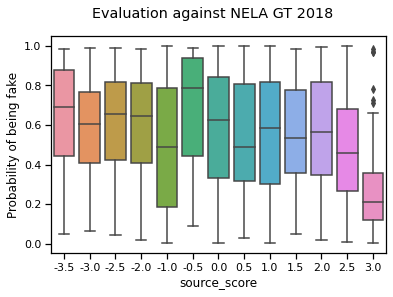

In [31]:
sample = nela_gt_2018_articles_df.sample(10000, random_state=42)

sample_encodings = np.array(
    [
        pretrained_fasttext.get_sentence_vector(s.lower().replace("\n", " "))
        for s in sample.text
    ]
)
predicted_probas = logistic_regression.predict_proba(sample_encodings)[:, 1]

plt.suptitle("Evaluation against NELA GT 2018")

ax = sns.boxplot(
    x=sample.source_score, y=predicted_probas
)  # , x_jitter=.1, scatter_kws={"alpha": 0.5})

ax.set_ylabel("Probability of being fake")

plt.savefig(FIGURES_DIR / "linear-evaluatation-against-nela.png")

del sample, sample_encodings, predicted_probas

In [32]:
nela_val_split = nela_gt_2018_articles_df[nela_gt_2018_articles_df.split == "val"]
nela_val_encodings = np.array(
    [
        pretrained_fasttext.get_sentence_vector(s.lower().replace("\n", " "))
        for s in nela_val_split.text
    ]
)

print(
    f"Accuracy {(logistic_regression.predict(nela_val_encodings) == nela_val_split.is_fake).mean()}"
)
print(
    f"ROC AUC {roc_auc_score(nela_val_split.is_fake, logistic_regression.predict_proba(nela_val_encodings)[:, 1])}"
)

Accuracy 0.5194977966242621
ROC AUC 0.5619255328181815


In [33]:
del nela_val_split, nela_val_encodings

In [33]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i : i + n]


def batched_preprocessing(
    articles_df: pd.DataFrame,
    ft_encoder,
    batch_size: int = 128,
    root_dir: Path = BASE_DATA_DIR,
):
    articles_df = articles_df.dropna(subset=["title"])
    for batch_indices in tqdm(chunks(articles_df.index, batch_size)):
        text_encodings = []
        for article_path in articles_df.loc[batch_indices].path:
            with open(root_dir / article_path, "r") as f:
                text = f.read().replace("\n", " ")
            text_encodings.append(ft_encoder.get_sentence_vector(text.lower()))
        text_encodings = np.array(text_encodings)
        title_encodings = np.array(
            [
                ft_encoder.get_sentence_vector(s.lower())
                for s in articles_df.loc[batch_indices].title
            ]
        )
        encodings = np.concatenate([text_encodings, title_encodings], axis=1)
        yield encodings, articles_df.loc[batch_indices].is_fake


def batched_predictions(articles: pd.DataFrame, ft_encoder, model, batch_size=128):
    for text_encodings, _ in batched_preprocessing(articles, ft_encoder, batch_size):
        preds = model.predict_proba(text_encodings)
        yield preds

I am not sure I assigned scores to sources correctly, however, I'm pretty sure that as we increase source score, proportion of reliable news increases. As I feared, model trained on the original dataset generalizes poorly. Let's train our model on articles I'm most confident about.

In [34]:
train_articles_df = nela_gt_2018_articles_df[nela_gt_2018_articles_df.split == "train"]
val_articles_df = nela_gt_2018_articles_df[nela_gt_2018_articles_df.split == "val"]

In [35]:
train_encodings = preprocessing.encode_articles(train_articles_df, pretrained_fasttext)
val_encodings = preprocessing.encode_articles(val_articles_df, pretrained_fasttext)
original_encodings = preprocessing.encode_articles(df_merged, pretrained_fasttext)

In [36]:
model = SGDClassifier(loss="log")
model.partial_fit(original_encodings, df_merged.is_fake, classes=[0, 1])

SGDClassifier(loss='log')

In [37]:
model.partial_fit(train_encodings, train_articles_df.is_fake, classes=[0, 1])
val_preds = model.predict_proba(val_encodings)
val_acc = ((val_preds[:, 1] > 0.5) == val_articles_df.is_fake).mean()
val_auc = roc_auc_score(val_articles_df.is_fake, val_preds[:, 1])
print(f"Validation accuracy: {val_acc}")
print(f"Validation AUC: {val_auc}")

Validation accuracy: 0.5550843934480751
Validation AUC: 0.8124496042601669


In [38]:
nela_gt_2018_articles_df.columns

Index(['path', 'title', 'date', 'source', 'source_score', 'text', 'is_fake',
       'split'],
      dtype='object')

In [39]:
visual_check = nela_gt_2018_articles_df.sample(n=10000)
predicted_probas = np.concatenate(
    list(batched_predictions(visual_check, pretrained_fasttext, model, batch_size=128))
)

0it [00:00, ?it/s]

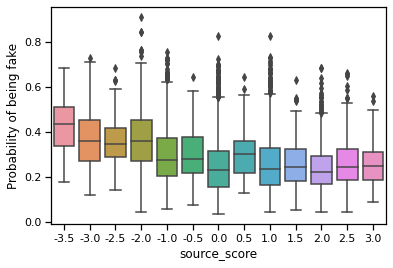

In [40]:
ax = sns.boxplot(x=visual_check.source_score, y=predicted_probas[:, 1])

ax.set_ylabel("Probability of being fake")

plt.savefig(
   FIGURES_DIR / "trained_nela-gt-2018-articles-probability-of-being-fake.png"
)

Model does have potential to separate true stories from fake ones. At least it's performance on training set is not absolutely atrocious.

Now I have two ideas:
1. I'm representing whole article as 300 numbers. I could give my model more information
2. Data might not be linearly separable, I can try more complex model.

Solution 2. is simpler to code, so I'll go with it first.

#### LightGBM

In [ ]:
raise NotImplementedError("Stop")

In [42]:
train_dataset = lgb.Dataset(train_encodings, label=train_articles_df.is_fake)
val_dataset = lgb.Dataset(val_encodings, label=val_articles_df.is_fake)
original_dataset = lgb.Dataset(original_encodings, label=df_merged.is_fake)

In [43]:
param = {
    "learning_rate": 0.05,
    "num_leaves": 15,
    "max_depth": 5,
    "objective": "binary",
    "min_data_in_leaf": train_articles_df.shape[0] // 100,
    "is_unbalance": True,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.5,
    "extra_trees": True,
    "l2_regularization": 1e-3,
    "path_smooth": 1e-5,
}
param["metric"] = "auc"
num_round = 100000
bst = lgb.train(
    param,
    train_dataset,
    num_round,
    # I fail to make lgbm only consider the first metric for early stopping
    # so I'm dropping original_dataset from val sets
    # I'll calculate auc by hand
    valid_sets=[val_dataset],
    valid_names=["val"],
    early_stopping_rounds=min(num_round // 10, 1000),
)
print(f"Best val auc: {bst.best_score}")
orig_preds = bst.predict(original_encodings, num_iteration=bst.best_iteration)
orig_auc = roc_auc_score(df_merged.is_fake, orig_preds)
print(f"Original dataset auc: {orig_auc}")
train_preds = bst.predict(train_encodings, num_iteration=bst.best_iteration)
train_auc = roc_auc_score(train_articles_df.is_fake, train_preds)
print(f"Training auc: {train_auc}")

with open(BASE_MODEL_DIR / "lightgbm_simple.pk", "wb") as f:
    pickle.dump(bst, f)

/home/julius/.conda/envs/jjuoda-DL.4/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 54969, number of negative: 130932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.560624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153000
[LightGBM] [Info] Number of data points in the train set: 185901, number of used features: 600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295690 -> initscore=-0.867909
[LightGBM] [Info] Start training from score -0.867909
[1]	val's auc: 0.572487
Training until validation scores don't improve for 1000 rounds
[2]	val's auc: 0.64099
[3]	val's auc: 0.649355
[4]	val's auc: 0.655637
[5]	val's auc: 0.658008
[6]	val's auc: 0.668905
[7]	val's auc: 0.686882
[8]	val's auc: 0.683244
[9]	val's auc: 0.688176
[10]	val's auc: 0.688362
[11]	val's auc: 0.695606
[12]	val's auc: 0.690935
[13]	val's auc: 0.687633
[14]	val's auc: 0.691396
[15]	val's auc: 0.699005
[16]	val's auc: 0.693882
[17]	val's auc: 0.69632
[18]	val's auc: 0.697

KeyboardInterrupt: 

Ok, my selected task to train models on is relevant.  
Auc on original dataset - even tho model did not see at all - is higher than on nela-gt-2018, data similar to one seen in training.

I've also played a bit with parameters, best val auc I got was about .85, way better than what I had before.

In [42]:
preds = []

bst = pickle.load(open(BASE_MODEL_DIR / "lightgbm_simple.pk", "rb"))

sample = (
    nela_gt_2018_articles_df[nela_gt_2018_articles_df.split == "pred"]
    .dropna(subset=["title"])
    .sample(n=10000)
)

for enc, labels in batched_preprocessing(sample, pretrained_fasttext, batch_size=128):
    preds.append(bst.predict(enc))
preds = np.concatenate(preds)

0it [00:00, ?it/s]

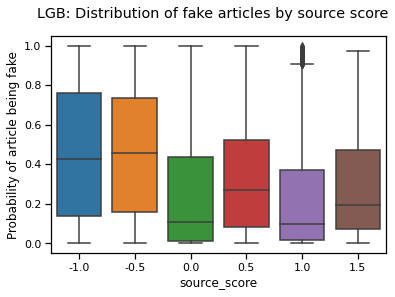

In [43]:
ax = sns.boxplot(x=sample.source_score, y=preds)
ax.set_ylabel("Probability of article being fake")

plt.suptitle("LGB: Distribution of fake articles by source score")
plt.savefig(FIGURES_DIR / "fake-articles-by-source-score-lgbm.png")

Ok, the trend looks as it should - decreasing probability of news being fake with source score increasing. Auc looks promising.

In [52]:
num_keywords = 300

title_tfidf_vectorizer = TfidfVectorizer(
    max_features=num_keywords,
    stop_words="english",
).fit(train_articles_df.title)

By scanning through, very American list.

In [53]:
text_tfidf_vectorizer = TfidfVectorizer(
    max_features=num_keywords,
    stop_words="english",
).fit(train_articles_df.title)

In [ ]:
with open(BASE_MODEL_DIR / "tfidf_title.pk", "wb") as f:
    pickle.dump(title_tfidf_vectorizer, f)

with open(BASE_MODEL_DIR / "tfidf_text", "wb") as f:
    pickle.dump(text_tfidf_vectorizer, f)

In [54]:
def get_tfidf_vectors(articles_df):
    title_vectors = title_tfidf_vectorizer.transform(articles_df.title).todense()
    text_vectors = text_tfidf_vectorizer.transform(articles_df.text).todense()
    return np.array(np.concatenate([title_vectors, text_vectors], axis=1))

In [55]:
train_features = np.concatenate(
    [train_encodings, get_tfidf_vectors(train_articles_df)], axis=1
)
val_features = np.concatenate(
    [val_encodings, get_tfidf_vectors(val_articles_df)], axis=1
)
original_features = np.concatenate(
    [original_encodings, get_tfidf_vectors(df_merged)], axis=1
)

In [ ]:
train_dataset = lgb.Dataset(train_features, label=train_articles_df.is_fake.values)
val_dataset = lgb.Dataset(val_features, label=val_articles_df.is_fake.values)
original_dataset = lgb.Dataset(original_features, label=df_merged.is_fake.values)

param = {
    "learning_rate": 0.05,
    "num_leaves": 15,
    "max_depth": 5,
    "objective": "binary",
    "min_data_in_leaf": train_articles_df.shape[0] // 100,
    "is_unbalance": True,
    "feature_fraction": 0.3,
    "extra_trees": True,
    "l2_regularization": 1e-3,
    "l1_regularization": 1e-3,
    "path_smooth": 1e-5,
    "max_bins": 2**6 - 1,
}
param["metric"] = "auc"
num_round = 100000
bst = lgb.train(
    param,
    train_dataset,
    num_round,
    valid_sets=[val_dataset],
    valid_names=["val"],
    early_stopping_rounds=min(num_round // 10, 1000),
)
print(f"Best val auc: {bst.best_score}")
orig_preds = bst.predict(original_features, num_iteration=bst.best_iteration)
orig_auc = roc_auc_score(df_merged.is_fake, orig_preds)
print(f"Original dataset auc: {orig_auc}")
train_preds = bst.predict(train_features, num_iteration=bst.best_iteration)
train_auc = roc_auc_score(train_articles_df.is_fake, train_preds)
print(f"Training auc: {train_auc}")

with open(BASE_MODEL_DIR / "lightgbm_with_tfidf.pk", "wb") as f:
    pickle.dump(bst, f)

/home/julius/.conda/envs/jjuoda-DL.4/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 54969, number of negative: 130932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.662190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58650
[LightGBM] [Info] Number of data points in the train set: 185901, number of used features: 931
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295690 -> initscore=-0.867909
[LightGBM] [Info] Start training from score -0.867909
[1]	val's auc: 0.593704
Training until validation scores don't improve for 1000 rounds
[2]	val's auc: 0.625309
[3]	val's auc: 0.631577
[4]	val's auc: 0.658103
[5]	val's auc: 0.663485
[6]	val's auc: 0.661571
[7]	val's auc: 0.684674
[8]	val's auc: 0.686489
[9]	val's auc: 0.689082
[10]	val's auc: 0.691543
[11]	val's auc: 0.688682
[12]	val's auc: 0.697289
[13]	val's auc: 0.701672
[14]	val's auc: 0.705202
[15]	val's auc: 0.713894
[16]	val's auc: 0.720443
[17]	val's auc: 0.723863
[18]	val's auc: 0.73

I've tried playing around, it seems that adding more features increased overfitting without improving performance on the validation set.  

Before moving to deep learning, let's try to model what I as a human was looking for - differences in tone and topics covered between fake and real news. Maybe K neighbors could pick that up?

### K methods

#### KNN

In [44]:
def get_metrics(
    features: Dict[str, np.ndarray],
    labels: Dict[str, np.ndarray],
    cb_pred_proba: Callable[[np.ndarray], np.ndarray],
) -> Dict[str, Dict[str, float]]:
    """Calculate auc and accuracy for each feature set.

    Args:
        features (Dict[str, np.ndarray]): features in form of {"train": train_features, ...}
        labels (Dict[str, np.ndarray]): labels in form of {"train": train_labels, ...}
        cb_pred_proba (Callable[[np.ndarray], np.ndarray]): function taking features
            and returning class probabilities

    Returns:
        Dict[str, Dict[str, float]]: metrics in form
            {"train": {"auc": train_auc, "accuracy": train_accuracy}, ...}
    """
    assert len(features) == len(labels)
    metrics = {k: {"auc": np.nan, "accuracy": np.nan} for k in features}
    for name, values in features.items():
        preds = cb_pred_proba(values)
        metrics[name]["auc"] = roc_auc_score(labels[name], preds)
        metrics[name]["accuracy"] = ((preds > 0.5) == labels[name]).mean()
    return metrics


def knn_predict_proba(neighbors, labels, n_neighbors):
    """Reimplements sklearn knn, but I avoid calculating distances multiple times"""
    return labels[neighbors[:, :n_neighbors]].mean(axis=1)


def resample(features: np.ndarray, labels: np.ndarray, sampler: BaseSampler = None):
    """Resample the data.

    Args:
        features (np.ndarray): features
        labels (np.ndarray): labels
        sampler (BaseSampler): sampler to use; it is fit to the data

    Returns:
        Tuple[np.ndarray, np.ndarray]: (resampled features, resampled labels)
    """
    if sampler:
        return sampler.fit_resample(features, labels)
    else:
        return features, labels


def evaluate_knn(
    features: Dict[str, np.ndarray],
    labels: Dict[str, np.ndarray],
    kmin: int = 1,
    kmax: int = 64,
    step_size: int = 1,
    sampler: BaseSampler = None,
    distance_metric: str = "euclidean",
) -> Dict[str, Dict[str, float]]:
    """Evaluate KNearestNeighbors classifier across a range of k values.

    Args:
        features (Dict[str, np.ndarray]): features in form of {"train": train_features, ...}
            at least train features is required
        labels (Dict[str, np.ndarray]): labels in form of {"train": train_labels, ...}
        kmin (int, optional): minimum k value to evaluate. Defaults to 1.
        kmax (int, optional): maximum k value to evaluate. Defaults to 512.
        step_size (int, optional): step size for k values. Defaults to 1.
        sampler (BaseSampler, optional): sampler to use. Defaults to None.
        distance_metric (str, optional): distance metric to use. Defaults to "euclidean".

    Returns:
        Dict[str, Dict[str, float]]: metrics in form
            {"train": {"auc": train_auc, "accuracy": train_accuracy}, ...}
    """
    assert len(features) == len(labels)
    for name in features:
        assert len(features[name]) == len(
            labels[name]
        ), f"{name} has {len(features[name])} features, but {len(labels[name])} labels"

    train_features_full, train_labels_full = resample(
        features["train"], labels["train"], sampler
    )
    knn_classifier = KNeighborsClassifier(n_neighbors=kmax, metric=distance_metric)
    knn_classifier.fit(train_features_full, train_labels_full)

    joblib.dump(
        knn_classifier,
        BASE_MODEL_DIR
        / f"knn_classifier_{sampler.__class__.__name__}_{distance_metric}.pkl",
    )

    # copy references so I can mess with dict in-place without modifying the original
    features = copy(features)
    # I don't need every training sample to calculate training metrics
    features["train"] = features["train"][:10000]
    labels["train"] = labels["train"][:10000]

    # most expensive part of this function is calculating distances
    # (we only care about neighbors, not distances)
    neighbors = {
        name: knn_classifier.kneighbors(features[name], return_distance=False)
        for name in tqdm(features, position=1)
    }

    metrics = []
    for n_neighbors in range(kmax, kmin, -step_size):
        metrics.append(
            {
                "n_neighbors": n_neighbors,
                **get_metrics(
                    neighbors,
                    labels,
                    lambda x: knn_predict_proba(x, train_labels_full, n_neighbors),
                ),
            }
        )

    return metrics

In [ ]:
raise NotImplementedError("Stop")

In [45]:
def to_dataframe(metrics):
    sep = "."  # it's actually important this is one symbol
    normalized = pd.json_normalize(metrics, sep=sep)
    metric_per_row = normalized.melt(
        id_vars=["sampler", "distance_metric", "n_neighbors"]
    )
    split_name_metric_name = metric_per_row.variable.str.split(sep, expand=True)
    metric_per_row["split"] = split_name_metric_name.iloc[:, 0]
    metric_per_row["metric"] = split_name_metric_name.iloc[:, 1]
    return metric_per_row.drop(columns=["variable"])

In [46]:
upsamplers = {
    # "smote": over_sampling.SMOTE(random_state=42),
    # "svm_smote": over_sampling.SVMSMOTE(random_state=42),
    # "adasyn": over_sampling.ADASYN(random_state=42),
    # "N/A": None,
}
distance_metrics = ["euclidean"]
metrics = []
with joblib.parallel_backend("threading", n_jobs=4):
    for sampler_name, sampler in tqdm(upsamplers.items(), position=0):
        for distance_metric in distance_metrics:
            for metrics_by_k in evaluate_knn(
                {
                    "train": train_encodings,
                    "val": val_encodings,
                    "original": original_encodings,
                },
                {
                    "train": train_articles_df.is_fake.values,
                    "val": val_articles_df.is_fake.values,
                    "original": df_merged.is_fake.values,
                },
                sampler=sampler,
                kmax=512,
                distance_metric=distance_metric,
            ):
                metrics.append(
                    {
                        "sampler": sampler_name,
                        "distance_metric": distance_metric,
                        **metrics_by_k,
                    }
                )


# metrics_df.to_csv(BASE_DATA_DIR / "processed/knn_results_fasttext.csv")

0it [00:00, ?it/s]

I'll make a table summarising knn results.

In [ ]:
results_df = pd.read_csv(
    BASE_DATA_DIR / "processed/knn_results_fasttext.csv", index_col=0
)

# I can't figure out how to disable pandas convertion from string N/A to pd.Na
# I'll just fill nas here
results_df.fillna(value="N/A", inplace=True)

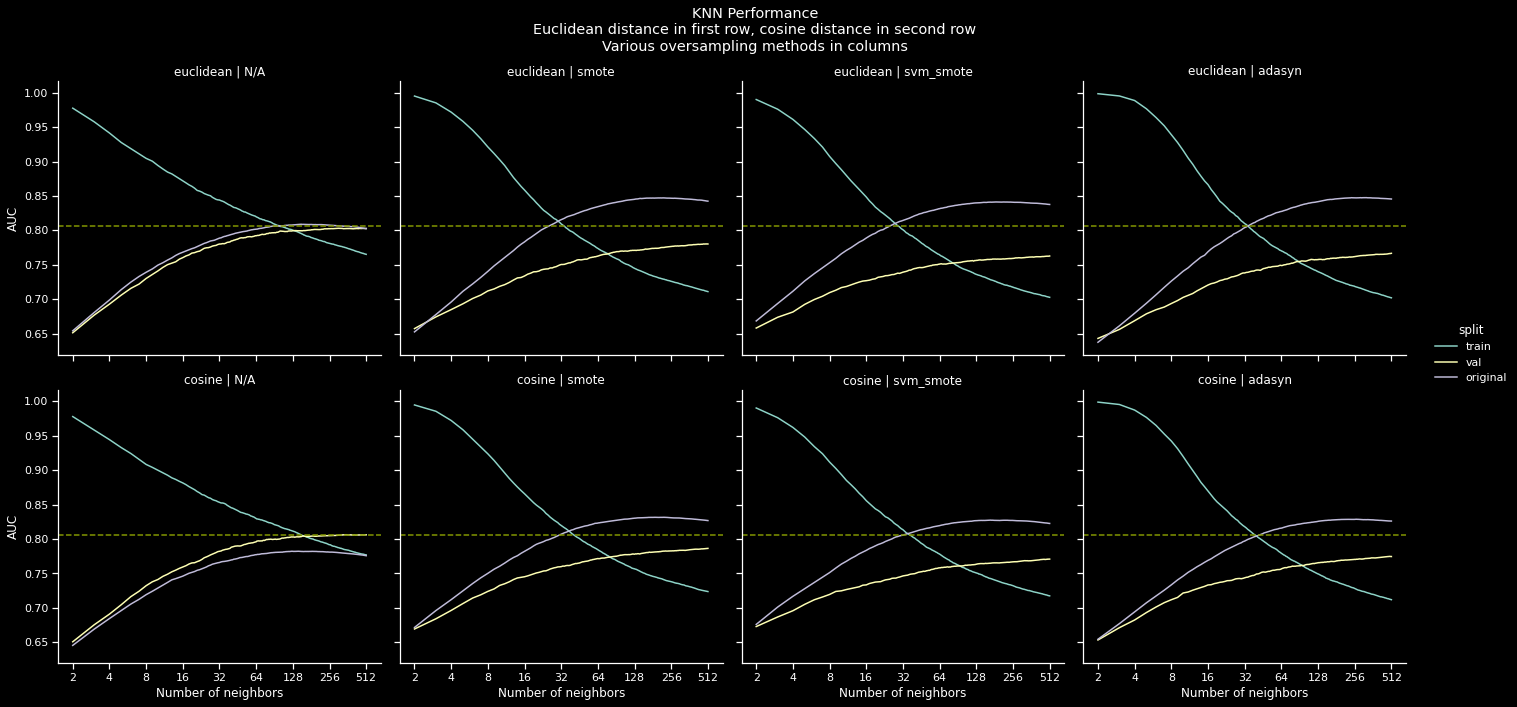

In [ ]:
sampler_order = ["N/A", "smote", "svm_smote", "adasyn"]

g = sns.relplot(
    data=results_df[results_df.metric == "auc"],
    x="n_neighbors",
    y="value",
    hue="split",
    col="sampler",
    row="distance_metric",
    kind="line",
    col_order=sampler_order,
)

best_auc_on_val = results_df[
    (results_df.metric == "auc") & (results_df.split == "val")
].value.max()

# no idea why g.refline or g.map(plt.axhline) don't work
for ax in g.axes.flat:
    ax.axhline(y=best_auc_on_val, color="#859900", linestyle="--")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="AUC", xlabel="Number of neighbors")

plt.suptitle(
    "KNN Performance\n"
    "Euclidean distance in first row, cosine distance in second row\n"
    "Various oversampling methods in columns"
)

plt.semilogx(base=2)
max_power = 9
plt.xticks(
    [2**i for i in range(1, max_power + 1)],
    [str(2**i) for i in range(1, max_power + 1)],
)
g.tight_layout()  # plt.tight_layout squishes legend into the plot
plt.savefig(FIGURES_DIR / "knn_results_fasttext.png")

Let's distill the view to only validation performance.

In [49]:
pivot = results_df[
    (results_df.split == "val")
    & (results_df.metric == "auc")
    & (results_df.distance_metric == "euclidean")
].pivot_table(index="sampler", columns="n_neighbors", values="value", aggfunc="mean")

<AxesSubplot:xlabel='n_neighbors', ylabel='sampler'>

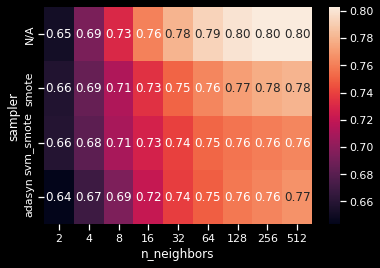

In [50]:
powers_of_two = [2**i for i in range(1, 10)]
sns.heatmap(pivot.loc[sampler_order, powers_of_two], annot=True, fmt=".2f")

So it's pretty clear that upsampling helps. Doesn't seem to particularly matter which upsampling method I use, as long as it's not KMeans :D
Admittedly, I didn't tune it but it needing tuning would be a reason to not use it.

... After I cleaned data a bit (mainly removing urls), not only I get a better result, but upsampling no longer helps o.o;  
It does help with performance on original dataset, but not on nela-gt-2018.

I'd likely use 32 or 64 neighbours, since even though more neighbours help, runtime gets prohibitive.

Let's see if extra tf-idf features help.

In [56]:
upsamplers = {
    "smote": over_sampling.SMOTE(random_state=42),
    "svm_smote": over_sampling.SVMSMOTE(random_state=42),
    "adasyn": over_sampling.ADASYN(random_state=42),
    "N/A": None,
}
distance_metrics = ["euclidean", "cosine"]
metrics = []
with joblib.parallel_backend("threading", n_jobs=4):
    for sampler_name, sampler in tqdm(upsamplers.items(), position=0):
        for distance_metric in distance_metrics:
            for metrics_by_k in evaluate_knn(
                {
                    "train": train_features,
                    "val": val_features,
                    "original": original_features,
                },
                {
                    "train": train_articles_df.is_fake.values,
                    "val": val_articles_df.is_fake.values,
                    "original": df_merged.is_fake.values,
                },
                sampler=sampler,
                kmax=512,
                distance_metric=distance_metric,
            ):
                metrics.append(
                    {
                        "sampler": sampler_name,
                        "distance_metric": distance_metric,
                        **metrics_by_k,
                    }
                )

  0%|          | 0/4 [00:00<?, ?it/s]

Again those extra tf-idf features didn't add anything and only hurt performance. Let's go do deep learning.